<a href="https://colab.research.google.com/github/harshitadd/FedBased_X-RayForCoVID/blob/master/FederatedCoVIDdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Importing Mini Batch Data 
import os 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# %tensorflow_version 1.x
import tensorflow as tf 

In [3]:
!pip install pydicom 
import pydicom 
import cv2
import matplotlib.pyplot as plt 

In [4]:
dcm_path=os.listdir('/content/drive/My Drive/Fed_Covid/minibatch/')
dcm_data={}

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

ctr=0
for file in dcm_path:
  name = '/content/drive/My Drive/Fed_Covid/minibatch/' + file
  temp = pydicom.dcmread(name)
  image = temp.pixel_array
  ## Enhanced contrast and added colour
  adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
  dcm_data[file]=adjusted
  ctr+=1
  print(ctr)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
# plt.imshow(image,cmap=plt.cm.bone)

In [0]:
# plt.imshow(adjusted,cmap=plt.cm.bone)
# alpha=1.2
# beta=1
# adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# plt.imshow(adjusted,cmap=plt.cm.bone)


In [96]:
print(len(dcm_data))

427


In [0]:
# import pickle
# with open('/content/features_dcm.bin','wb') as file:
#   pickle.dump(dcm_data,file)

In [0]:
import csv 
labels=[]
with open('/content/drive/My Drive/Fed_Covid/stage_2_train_labels.csv','r') as file:
  reader = csv.reader(file)
  for row in reader:
    labels.append(row)

In [6]:
print(len(labels))
print(len(dcm_data))

30228
427


In [0]:
pid=[]
dicom=[]
label=[]
cid = 0
for PID in labels:
  for key in dcm_data:
    if(key[:-4]==PID[0]):
      # pid.append(key)
      dicom.append(dcm_data[key])
      label.append(PID[5])
      

In [8]:
print(len(dicom))
print(len(label))

429
429


In [0]:
## Making Training DF 
import pandas as pd
final_data = pd.DataFrame()
# final_data['PatientID']=pid 
final_data['dicom']=dicom
final_data['label']=label
# final_data['clientID'] = cid

In [34]:
final_data

,dicom,label
0,"[[3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,...",0
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0
2,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",0
3,"[[3, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...
424,"[[3, 4, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,...",1
425,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...",0
426,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 10, 44, ...",0
427,"[[104, 96, 93, 86, 69, 52, 38, 27, 14, 10, 8, ...",0


In [11]:
final_data.loc[0:99,'clientID'] = '0'
final_data.loc[100:199,'clientID'] = '1'
final_data.loc[200:299,'clientID'] = '2'
final_data.loc[300:428,'clientID'] = '3'
final_data

,dicom,label,clientID
0,"[[3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,...",0,0
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,0
2,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",0,0
3,"[[3, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0
...,...,...,...
424,"[[3, 4, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,...",1,3
425,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...",0,3
426,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 10, 44, ...",0,3
427,"[[104, 96, 93, 86, 69, 52, 38, 27, 14, 10, 8, ...",0,3


In [0]:
client_ids=['0','1','2','3']

In [0]:
#split client id into train and test clients
client_ids = df['clientID'].unique()
train_client_ids = ['1','3']
test_client_ids = [x for x in client_ids if x not in train_client_ids]
# train_client_ids = client_ids.sample(frac=0.5).tolist()
# test_client_ids = [x for x in client_ids if x not in train_client_ids]

In [0]:
type(final_data)
client_data = final_data

In [0]:
client_data = client_data.values.tolist()

In [0]:
print(client_data)

In [0]:
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500
NUM_CLIENTS = 4

In [0]:
def preprocess(dataset):
  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['dicom'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)

In [0]:
df = final_data

In [0]:
def create_tf_dataset_for_client(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
  client_data = df[df['clientID'] == client_id]
  # dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
  dataset = tf.data.Dataset.from_tensor_slices(client_data.values.tolist())
  dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
  print(type(dataset))
  return dataset

In [0]:
def make_federated_data(client_data, client_ids):
  for x in client_ids:
    return create_tf_dataset_for_client(x) 




  # return [preprocess(create_tf_dataset_for_client(x))
  #         for x in client_ids]

In [0]:
import numpy as np

In [0]:
client_set = set(final_data.clientID)

In [0]:
client_set = list(client_set)

In [19]:
print(client_set)

['3', '1', '0', '2']


In [0]:
final_data = final_data.values.tolist()

In [0]:
# final_data = tf.convert_to_tensor(final_data)

In [0]:
client_set=[1,2,3,4]

In [23]:
# sample_clients = final_data.clientID[0: NUM_CLIENTS] -- returning 0,0,0,0
federated_train_data = make_federated_data(final_data, client_set)

ValueError: ignored

In [0]:
def create_tf_dataset_for_client_fn(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
  client_data = df[df['clientID'] == client_id]
  # dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
  dataset = tf.data.Dataset.from_tensor_slices(client_data.values.tolist())
  dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
  return dataset

In [147]:
!pip install tensorflow_core

ERROR: Could not find a version that satisfies the requirement tensorflow_core (from versions: none)
ERROR: No matching distribution found for tensorflow_core


In [148]:
# tf.compat.v1.enable_v2_behavior()
import tensorflow_federated as tff

ModuleNotFoundError: ignored

In [144]:
## Establishing simulation
source = tff.simulation.ClientData.from_clients_and_fn(
  ['client_0','client_1','client_2','client_3'], create_tf_dataset_for_client_fn)

NameError: ignored

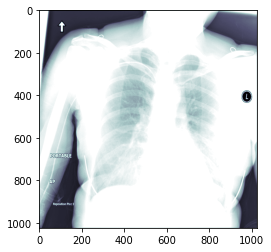

In [0]:
plt.imshow(dicom[78], cmap=plt.cm.bone)

In [0]:
import numpy as np

In [0]:
dicom = np.array(dicom)
label = np.array(label,dtype=np.int16)

In [0]:
print(len(dicom))
print(len(label))

429
429


In [0]:
##Preparing train/test data 
x_train,x_test,y_train,y_test=train_test_split(dicom,label,test_size=0.3)

In [0]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))


(300, 1024, 1024)
(300,)
(129, 1024, 1024)
(129,)


In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Conv1D,Flatten

In [0]:
tf.__version__

'2.2.0-rc1'

In [0]:
model = Sequential()

In [0]:
print(np.shape(x_train))

(300, 1024, 1024)


In [0]:
#Conv Net for training 

model.add(Conv1D(64, kernel_size=6, activation='relu', input_shape=(1024,1024)))
model.add(Conv1D(32, kernel_size=6, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))


In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1019, 64)          393280    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1014, 32)          12320     
_________________________________________________________________
flatten_7 (Flatten)          (None, 32448)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 64898     
Total params: 470,498
Trainable params: 470,498
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(x_train, y_train, validation_split = 0.33, epochs = 10,verbose = 1, batch_size = 32, shuffle = True)

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 7.6377 - accuracy: 0.7950 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 3/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 7.6415 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 5/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 6/10
7/7 [==============================] - 12s 2s/step - loss: 7.6415 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 7.6403 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 8/10
7/7 [==================

In [0]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.791


PYTORCH IMPLEMENTATION


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [29]:
!pip install syft

     |████████████████████████████████| 348kB 3.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 2.1MB 38.2MB/s 
     |████████████████████████████████| 1.8MB 36.9MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 1.3MB 35.7MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=5f50eafd0c6947163ae676b392f30ac71fb2faec9d5d904a7c54f2724684662b
  Stored in directory: /root/.cache/pip/wheels/f8/dc/36/dcb6bf0f1b9907e7b710ace63e64d08e7022340909315fdea4
Successfully built phe
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, b

In [0]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob -- HOSPITAL 1 
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice -- HOSPITAL 2 

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


In [0]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [35]:
final_data

,dicom,label
0,"[[3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,...",0
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0
2,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",0
3,"[[3, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...
424,"[[3, 4, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,...",1
425,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...",0
426,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 10, 44, ...",0
427,"[[104, 96, 93, 86, 69, 52, 38, 27, 14, 10, 8, ...",0


In [0]:
# class SVHNDataset(Dataset):

#     def __init__(self,features,labels,transform=None):
        
#         """Args:
             
#              images (Numpy Array): Image Data
#              labels (Numpy Array): Labels corresponding to each image
#              transform (Optional): If any torch transform has to be performed on the dataset
             
#         """
        
#         "Attributes self.data and self.targets must be initialized."
        
#         #<--Data must be initialized as self.data,self.train_data or self.test_data
#         self.data=features
#         #<--Targets must be initialized as self.targets,self.test_labels or self.train_labels
#         self.targets=labels
        
#         #<--The data and target must be converted to torch tensors before it is returned by __getitem__ method
#         self.to_torchtensor()
        
#         #<--If any transforms have to be performed on the dataset
#         self.transform = transform
        
        
#     def to_torchtensor(self):
        
#         "Transform Numpy Arrays to Torch tensors."
        
#         self.data=torch.from_numpy(self.data)
#         self.labels=torch.from_numpy(self.targets)
    
        
#     def __len__(self):
        
#         """Required Method
            
#            Returns:
        
#                 Length [int]: Length of Dataset/batches
        
#         """
        
#         return len(self.data)
    

#     def __getitem__(self, idx):
        
#         """Required Method
        
#            The output of this method must be torch tensors since torch tensors are overloaded 
#            with share() method which is used to share data to workers.
        
#            Args:
                 
#                  idx [integer]: The index of required batch/example
                 
#            Returns:
                 
#                  Data [Torch Tensor]:     The training examples
#                  Target [ Torch Tensor]:  Corresponding labels of training examples 
        
#         """
        
#         sample=self.data[idx]
#         target=self.targets[idx]
                
#         if self.transform:
#             sample = self.transform(sample)

#         return sample,target

CHECK THIS OUT 


In [0]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.3)

In [0]:
features=dicom
labels=label

In [47]:
type(features)

list

In [0]:
features = np.array(features, dtype=np.int16)
labels = np.array(label,dtype=np.int16)

In [0]:

#Converting to torch tensors
features = torch.from_numpy(features)
labels= torch.from_numpy(labels)

In [0]:
import numpy as np

In [0]:
base=sy.BaseDataset(X_train,y_train)

In [0]:
base_federated=base.federate((bob, alice))

In [0]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
                         base_federated,batch_size=args.batch_size)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(64, 1024, 1024)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "fed.pt")